imports

In [1]:
import matplotlib.pyplot as plt
import torch
import sys
import os
from sklearn.metrics import f1_score
from tqdm.notebook import tqdm as tqdm
from tqdm.auto import trange
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from myhelpers import config_plots, TrialStatistics
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName, getDatasetName
config_plots.global_settings()

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish"
experimentName="biology_paper_curated4_Easy50_tryphylogeny_2"

generate_confusion_matrix = False

cuda=0

Cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 0


Setup

In [4]:
config_parser = ConfigParser(experimentsPath, dataPath, experimentName)

experimentPathAndName = os.path.join(experimentsPath, experimentName)

# instantiate trial stat object
results_dir = os.path.join(experimentPathAndName, "results")
ts = TrialStatistics.TrialStatistics(results_dir)
ts_coarse = TrialStatistics.TrialStatistics(results_dir, "coarse")

datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)

paramsIterator = config_parser.getExperiments()  
number_of_experiments = sum(1 for e in paramsIterator)  

Show and save trial statistics

In [5]:

with tqdm(total=number_of_experiments, desc="experiment") as bar:
    for experiment_params in config_parser.getExperiments():
        print(experiment_params)

        # For analyzing experiments, we don't care about augmentation
        datasetManager.updateParams(config_parser.fixPaths({**experiment_params,**{'augmented': False}}))
        train_loader, validation_loader, test_loader = datasetManager.getLoaders()
        fineList = train_loader.dataset.csv_processor.getFineList()
        coarseList = train_loader.dataset.csv_processor.getCoarseList()
        architecture = {
            "fine": len(fineList),
            "coarse" : len(coarseList)
        }


        
        # Loop through n trials
        for i in trange(experiment_params["numOfTrials"], desc="trial"):
            modelName = getModelName(experiment_params, i)
            trialName = os.path.join(experimentPathAndName, modelName)
            
            # Train/Load model
            print(CNN.getModelFile(trialName))
            model = CNN.create_model(architecture, experiment_params, device=cuda)
            if os.path.exists(CNN.getModelFile(trialName)):
                df, epochs, time_elapsed = CNN.loadModel(model, trialName, device=cuda)
                
                # Update trial outcomes for statistics
                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, device=cuda)
                loss = CNN.getCrossEntropy(predlist, lbllist)
                avg_prob = CNN.getAvgProbCorrectGuess(predlist, lbllist)
                topk = CNN.top_k_acc(predlist, lbllist, topk=(3,5))
                
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                labels =list(map(lambda x: x[1] + " - " + str(x[0]), enumerate(fineList))) 
                ts.addTrialPredictions(experiment_params,i, predlist, lbllist, labels)
                micro_f1 = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(test_loader, model, experiment_params, 'coarse', device=cuda)
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                labels =list(map(lambda x: x[1] + " - " + str(x[0]), enumerate(coarseList)))
                ts_coarse.addTrialPredictions(experiment_params,i, predlist, lbllist, labels)
                micro_f1_coarse = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                predlist, lbllist = CNN.getLoaderPredictionProbabilities(validation_loader, model, experiment_params, device=cuda)
                predlist, lbllist = CNN.getPredictions(predlist, lbllist)
                macro_f1_val = f1_score(lbllist.cpu(), predlist.cpu(), average='macro')

                score = {'loss': loss,
                         'average correct guess prob': avg_prob,
                         'macro f1 test fine': micro_f1,
                         'macro f1 test coarse': micro_f1_coarse,
                         'macro f1 validation fine': macro_f1_val,
                         'time': time_elapsed,
                         'epochs': epochs,
                         'top-3': topk[0].cpu().numpy(),
                         'top-5': topk[1].cpu().numpy(),
                        }

                ts.addTrial(experiment_params,
                    score, i)
            else:
                print("Model {0} not found!".format(trialName))
        
        bar.update()

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 16, 'learning_rate': 0.0001, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': False, 'phylogeny_loss': True}
Creating datasets...
{'Alosa chrysochloris': 482298, 'Carassius auratus': 1005907, 'Cyprinus carpio': 429083, 'Esox americanus': 496115, 'Gambusia affinis': 617445, 'Lepisosteus osseus': 519445, 'Lepisosteus platostomus': 731608, 'Lepomis auritus': 1002718, 'Lepomis cyanellus': 476361, 'Lepomis gibbosus': 670266, 'Lepomis gulosus': 476359, 'Lepomis humilis': 892772, 'Lepomis macrochirus': 836783, 'Lepomis megalotis': 271249, 'Lepomis microlophus': 271244, 'Morone chrysops': 246133, 'Morone mississippiensis': 769290, 'Notropis atherinoides': 636312, 'Notropis blennius': 419165, 'Notropis bo

Lepomis cyanellus Notropis percobromus
ott476361 ott403731
Lepomis cyanellus Notropis stramineus
ott476361 ott351741
Lepomis cyanellus Notropis telescopus
ott476361 ott550190
Lepomis cyanellus Notropis texanus
ott476361 ott550208
Lepomis cyanellus Notropis volucellus
ott476361 ott351735
Lepomis cyanellus Notropis wickliffi
ott476361 ott563834
Lepomis cyanellus Noturus exilis
ott476361 ott678206
Lepomis cyanellus Noturus flavus
ott476361 ott101864
Lepomis cyanellus Noturus gyrinus
ott476361 ott652777
Lepomis cyanellus Noturus miurus
ott476361 ott282530
Lepomis cyanellus Noturus nocturnus
ott476361 ott621586
Lepomis cyanellus Phenacobius mirabilis
ott476361 ott945111
Lepomis gibbosus Alosa chrysochloris
ott670266 ott482298
Lepomis gibbosus Carassius auratus
ott670266 ott1005907
Lepomis gibbosus Cyprinus carpio
ott670266 ott429083
Lepomis gibbosus Esox americanus
ott670266 ott496115
Lepomis gibbosus Gambusia affinis
ott670266 ott617445
Lepomis gibbosus Lepisosteus osseus
ott670266 ott5194

ott419165 ott652777
Notropis blennius Noturus miurus
ott419165 ott282530
Notropis blennius Noturus nocturnus
ott419165 ott621586
Notropis blennius Phenacobius mirabilis
ott419165 ott945111
Notropis boops Alosa chrysochloris
ott443777 ott482298
Notropis boops Carassius auratus
ott443777 ott1005907
Notropis boops Cyprinus carpio
ott443777 ott429083
Notropis boops Esox americanus
ott443777 ott496115
Notropis boops Gambusia affinis
ott443777 ott617445
Notropis boops Lepisosteus osseus
ott443777 ott519445
Notropis boops Lepisosteus platostomus
ott443777 ott731608
Notropis boops Lepomis auritus
ott443777 ott1002718
Notropis boops Lepomis cyanellus
ott443777 ott476361
Notropis boops Lepomis gibbosus
ott443777 ott670266
Notropis boops Lepomis gulosus
ott443777 ott476359
Notropis boops Lepomis humilis
ott443777 ott892772
Notropis boops Lepomis macrochirus
ott443777 ott836783
Notropis boops Lepomis megalotis
ott443777 ott271249
Notropis boops Lepomis microlophus
ott443777 ott271244
Notropis boop

ott550190 ott670266
Notropis telescopus Lepomis gulosus
ott550190 ott476359
Notropis telescopus Lepomis humilis
ott550190 ott892772
Notropis telescopus Lepomis macrochirus
ott550190 ott836783
Notropis telescopus Lepomis megalotis
ott550190 ott271249
Notropis telescopus Lepomis microlophus
ott550190 ott271244
Notropis telescopus Morone chrysops
ott550190 ott246133
Notropis telescopus Morone mississippiensis
ott550190 ott769290
Notropis telescopus Notropis atherinoides
ott550190 ott636312
Notropis telescopus Notropis blennius
ott550190 ott419165
Notropis telescopus Notropis boops
ott550190 ott443777
Notropis telescopus Notropis buccatus
ott550190 ott269524
Notropis telescopus Notropis buchanani
ott550190 ott555686
Notropis telescopus Notropis dorsalis
ott550190 ott419160
Notropis telescopus Notropis hudsonius
ott550190 ott135051
Notropis telescopus Notropis leuciodus
ott550190 ott338652
Notropis telescopus Notropis nubilus
ott550190 ott550199
Notropis telescopus Notropis percobromus
ott5

Phenacobius mirabilis Lepomis cyanellus
ott945111 ott476361
Phenacobius mirabilis Lepomis gibbosus
ott945111 ott670266
Phenacobius mirabilis Lepomis gulosus
ott945111 ott476359
Phenacobius mirabilis Lepomis humilis
ott945111 ott892772
Phenacobius mirabilis Lepomis macrochirus
ott945111 ott836783
Phenacobius mirabilis Lepomis megalotis
ott945111 ott271249
Phenacobius mirabilis Lepomis microlophus
ott945111 ott271244
Phenacobius mirabilis Morone chrysops
ott945111 ott246133
Phenacobius mirabilis Morone mississippiensis
ott945111 ott769290
Phenacobius mirabilis Notropis atherinoides
ott945111 ott636312
Phenacobius mirabilis Notropis blennius
ott945111 ott419165
Phenacobius mirabilis Notropis boops
ott945111 ott443777
Phenacobius mirabilis Notropis buccatus
ott945111 ott269524
Phenacobius mirabilis Notropis buchanani
ott945111 ott555686
Phenacobius mirabilis Notropis dorsalis
ott945111 ott419160
Phenacobius mirabilis Notropis hudsonius
ott945111 ott135051
Phenacobius mirabilis Notropis leu

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/2590730e79061328da744c14706fd7db472eaf6a1366d42a98b32ec3/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/38ec0c7a4ca139cc00bd0469def4c2513093d090b4e63357b3acdcdf/trial_confusion_matrix_2590730e79061328da744c14706fd7db472eaf6a1366d42a98b32ec3.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/38ec0c7a4ca139cc00bd0469def4c2513093d090b4e63357b3acdcdf/coarse_trial_confusion_matrix_2590730e79061328da744c14706fd7db472eaf6a1366d42a98b32ec3.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 16, 'learning_rate': 5e-05, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': 

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/6cc44d249dccb342c55455ba84a448c1ea98175a2540138a2c20eebf/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/6a8422f26f83cfcd82b97f200423dfc840a58f8e2bbd6949e93fc69a/trial_confusion_matrix_6cc44d249dccb342c55455ba84a448c1ea98175a2540138a2c20eebf.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/6a8422f26f83cfcd82b97f200423dfc840a58f8e2bbd6949e93fc69a/coarse_trial_confusion_matrix_6cc44d249dccb342c55455ba84a448c1ea98175a2540138a2c20eebf.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 16, 'learning_rate': 1e-05, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': 

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/d8fe98663fa187e59579f5ba453493bf5767cefa1f95b93e668918df/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/47018b7705d9ad44aab465b272062b19d583d1c2f8de9afed58feb9d/trial_confusion_matrix_d8fe98663fa187e59579f5ba453493bf5767cefa1f95b93e668918df.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/47018b7705d9ad44aab465b272062b19d583d1c2f8de9afed58feb9d/coarse_trial_confusion_matrix_d8fe98663fa187e59579f5ba453493bf5767cefa1f95b93e668918df.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 16, 'learning_rate': 5e-06, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': 

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/17e2ebc4b9760bc1ddc13e1bf5de66c4b33f5a9bbf8a4428f6dccd2c/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/5f7d9ba727514e19156eebc94ef8130c8c4862a8a296102e5f96f967/trial_confusion_matrix_17e2ebc4b9760bc1ddc13e1bf5de66c4b33f5a9bbf8a4428f6dccd2c.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/5f7d9ba727514e19156eebc94ef8130c8c4862a8a296102e5f96f967/coarse_trial_confusion_matrix_17e2ebc4b9760bc1ddc13e1bf5de66c4b33f5a9bbf8a4428f6dccd2c.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 8, 'learning_rate': 0.0001, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': 

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/6460d95dfc050e404141804e1594dab4e917d8ad892ac074d90bba5b/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/833840a3408bad0eede4939c6a172e3dd263fc47ad509ba6d34a0898/trial_confusion_matrix_6460d95dfc050e404141804e1594dab4e917d8ad892ac074d90bba5b.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/833840a3408bad0eede4939c6a172e3dd263fc47ad509ba6d34a0898/coarse_trial_confusion_matrix_6460d95dfc050e404141804e1594dab4e917d8ad892ac074d90bba5b.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 8, 'learning_rate': 5e-05, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': F

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/eeac66a1afbf9cc4d81e9aecb201b02064bd8fd418ce8c38a9272347/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/76403d0821562b5b35e598520d52add0424815850de95a8dd85a49fd/trial_confusion_matrix_eeac66a1afbf9cc4d81e9aecb201b02064bd8fd418ce8c38a9272347.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/76403d0821562b5b35e598520d52add0424815850de95a8dd85a49fd/coarse_trial_confusion_matrix_eeac66a1afbf9cc4d81e9aecb201b02064bd8fd418ce8c38a9272347.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 8, 'learning_rate': 1e-05, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': F

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/e5f60ca95889b971b2426f3287d2c8f15c11750776ed3a27ec6aa160/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/96b27b9bc824f84bfb248d99b94490bddac885611b26ef0d60f1989b/trial_confusion_matrix_e5f60ca95889b971b2426f3287d2c8f15c11750776ed3a27ec6aa160.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/96b27b9bc824f84bfb248d99b94490bddac885611b26ef0d60f1989b/coarse_trial_confusion_matrix_e5f60ca95889b971b2426f3287d2c8f15c11750776ed3a27ec6aa160.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 8, 'learning_rate': 5e-06, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': F

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/54d76a1605f42ebb2626b506cf606e5f31585af25c4b5c3100247860/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/286e3eaee9cf5b78a31527bdd171c8063755c3982fb1d5e77aff1251/trial_confusion_matrix_54d76a1605f42ebb2626b506cf606e5f31585af25c4b5c3100247860.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/286e3eaee9cf5b78a31527bdd171c8063755c3982fb1d5e77aff1251/coarse_trial_confusion_matrix_54d76a1605f42ebb2626b506cf606e5f31585af25c4b5c3100247860.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 32, 'learning_rate': 0.0001, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop':

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/b25b42be08a4cbb2f5a33b1fa90e47bc26e108d22803b884566320ae/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/1487eec8bcb9b5176e662736f2b9ed2dda4167d97bc85af86c10b1c9/trial_confusion_matrix_b25b42be08a4cbb2f5a33b1fa90e47bc26e108d22803b884566320ae.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/1487eec8bcb9b5176e662736f2b9ed2dda4167d97bc85af86c10b1c9/coarse_trial_confusion_matrix_b25b42be08a4cbb2f5a33b1fa90e47bc26e108d22803b884566320ae.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 32, 'learning_rate': 5e-05, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': 

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/7effc62c9f4fcd75eefa892bcfe10583655f622c96db706edb2a5f2a/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/f4e29eb202e4a20f644560c074f0a27de2f9ac4c2fd4e85525b4ad98/trial_confusion_matrix_7effc62c9f4fcd75eefa892bcfe10583655f622c96db706edb2a5f2a.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/f4e29eb202e4a20f644560c074f0a27de2f9ac4c2fd4e85525b4ad98/coarse_trial_confusion_matrix_7effc62c9f4fcd75eefa892bcfe10583655f622c96db706edb2a5f2a.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 32, 'learning_rate': 1e-05, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': 

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/a1860fec06a3f58e536ff9fc70ac8be60a5f2b59afd1db5bc346af34/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/0523a3c88263e8e124d40e67b442058074772bdd0f290c0b71ebb65c/trial_confusion_matrix_a1860fec06a3f58e536ff9fc70ac8be60a5f2b59afd1db5bc346af34.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/0523a3c88263e8e124d40e67b442058074772bdd0f290c0b71ebb65c/coarse_trial_confusion_matrix_a1860fec06a3f58e536ff9fc70ac8be60a5f2b59afd1db5bc346af34.csv

{'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 32, 'learning_rate': 5e-06, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.01, 'unsupervisedOnTest': False, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.015, 'adaptive_alpha': 0.8, 'noSpeciesBackprop': 

/raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/models/4f9f353c511d8458512e17f8596c9e2dd71a7ed0360e5596a7b9c6e8/finalModel.pt
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/be703c622a74f8bb7b1755c06fe58c86088413de2ed65a899ae446a3/trial_confusion_matrix_4f9f353c511d8458512e17f8596c9e2dd71a7ed0360e5596a7b9c6e8.csv
Saving  /raid/elhamod/Fish/experiments/biology_paper_curated4_Easy50_tryphylogeny_2/results/be703c622a74f8bb7b1755c06fe58c86088413de2ed65a899ae446a3/coarse_trial_confusion_matrix_4f9f353c511d8458512e17f8596c9e2dd71a7ed0360e5596a7b9c6e8.csv




In [6]:
# Save experiment results
ts.saveStatistics()
ts.showStatistics()

In [7]:
# ts.df.replace('/','', regex=True).replace('_','', regex=True).groupby(['modelType']).mean()

In [8]:
ts.saveStatistics(False)
ts.showStatistics(False)

,image_path,suffix,img_res,augmented,batchSize,learning_rate,numOfTrials,fc_layers,modelType,lambda,unsupervisedOnTest,tl_model,link_layer,adaptive_smoothing,adaptive_lambda,adaptive_alpha,noSpeciesBackprop,phylogeny_loss,loss,average correct guess prob,macro f1 test fine,macro f1 test coarse,macro f1 validation fine,time,epochs,top-3,top-5,experimentHash,trial,trialHash
0,Curated4/Easy_50,None,448,True,16,0.000100,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.619670,0.044240,0.818670,0.677088,0.818068,3284.467871,30.0,93.947372,95.263161,38ec0c7a4ca139cc00bd0469def4c2513093d090b4e63357b3acdcdf,0,2590730e79061328da744c14706fd7db472eaf6a1366d42a98b32ec3
1,Curated4/Easy_50,None,448,True,16,0.000050,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.621679,0.042231,0.795467,0.336853,0.780320,4436.642577,40.0,95.789474,98.157898,6a8422f26f83cfcd82b97f200423dfc840a58f8e2bbd6949e93fc69a,0,6cc44d249dccb342c55455ba84a448c1ea98175a2540138a2c20eebf
2,Curated4/Easy_50,None,448,True,16,0.000010,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.633864,0.030041,0.230463,0.064732,0.241300,1565.751717,14.0,47.368423,58.947372,47018b7705d9ad44aab465b272062b19d583d1c2f8de9afed58feb9d,0,d8fe98663fa187e59579f5ba453493bf5767cefa1f95b93e668918df
3,Curated4/Easy_50,None,448,True,16,0.000005,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.634501,0.029407,0.126186,0.060507,0.132652,1569.260226,14.0,31.578949,43.157898,5f7d9ba727514e19156eebc94ef8130c8c4862a8a296102e5f96f967,0,17e2ebc4b9760bc1ddc13e1bf5de66c4b33f5a9bbf8a4428f6dccd2c
4,Curated4/Easy_50,None,448,True,8,0.000100,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.615276,0.048641,0.737774,0.784655,0.743133,3972.820279,35.0,93.157898,95.263161,833840a3408bad0eede4939c6a172e3dd263fc47ad509ba6d34a0898,0,6460d95dfc050e404141804e1594dab4e917d8ad892ac074d90bba5b
5,Curated4/Easy_50,None,448,True,8,0.000050,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.625719,0.038189,0.692963,0.234052,0.668000,3193.106420,28.0,92.631584,95.000000,76403d0821562b5b35e598520d52add0424815850de95a8dd85a49fd,0,eeac66a1afbf9cc4d81e9aecb201b02064bd8fd418ce8c38a9272347
6,Curated4/Easy_50,None,448,True,8,0.000010,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.629112,0.034793,0.571599,0.131490,0.597784,4780.501048,42.0,83.947372,90.789474,96b27b9bc824f84bfb248d99b94490bddac885611b26ef0d60f1989b,0,e5f60ca95889b971b2426f3287d2c8f15c11750776ed3a27ec6aa160
7,Curated4/Easy_50,None,448,True,8,0.000005,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.627586,0.036320,0.622829,0.139333,0.671119,8064.144048,71.0,88.947372,95.789474,286e3eaee9cf5b78a31527bdd171c8063755c3982fb1d5e77aff1251,0,54d76a1605f42ebb2626b506cf606e5f31585af25c4b5c3100247860
8,Curated4/Easy_50,None,448,True,32,0.000100,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.615630,0.048282,0.866483,0.667747,0.846446,4948.505291,43.0,97.105270,98.684212,1487eec8bcb9b5176e662736f2b9ed2dda4167d97bc85af86c10b1c9,0,b25b42be08a4cbb2f5a33b1fa90e47bc26e108d22803b884566320ae
9,Curated4/Easy_50,None,448,True,32,0.000050,1,1,BB,0.01,False,ResNet18,avgpool,True,0.015,0.8,False,True,3.627799,0.036107,0.696574,0.217857,0.689935,3521.256912,31.0,91.315796,95.789474,f4e29eb202e4a20f644560c074f0a27de2f9ac4c2fd4e85525b4ad98,0,7effc62c9f4fcd75eefa892bcfe10583655f622c96db706edb2a5f2a


Show and save confusion matrix

In [9]:
if generate_confusion_matrix:
    with tqdm(total=number_of_experiments, desc="experiment") as bar:
        for experiment_params in config_parser.getExperiments():
            print(experiment_params)

            ts.printTrialConfusionMatrix(experiment_params, fineList , printOutput=True)
            ts_coarse.printTrialConfusionMatrix(experiment_params,  coarseList, printOutput=True)
            
            datasetManager.updateParams(config_parser.fixPaths({**experiment_params,**{'augmented': False}}))
            train_loader, validation_loader, test_loader = datasetManager.getLoaders()
            ts.printF1table(experiment_params, test_loader.dataset)

            bar.update()

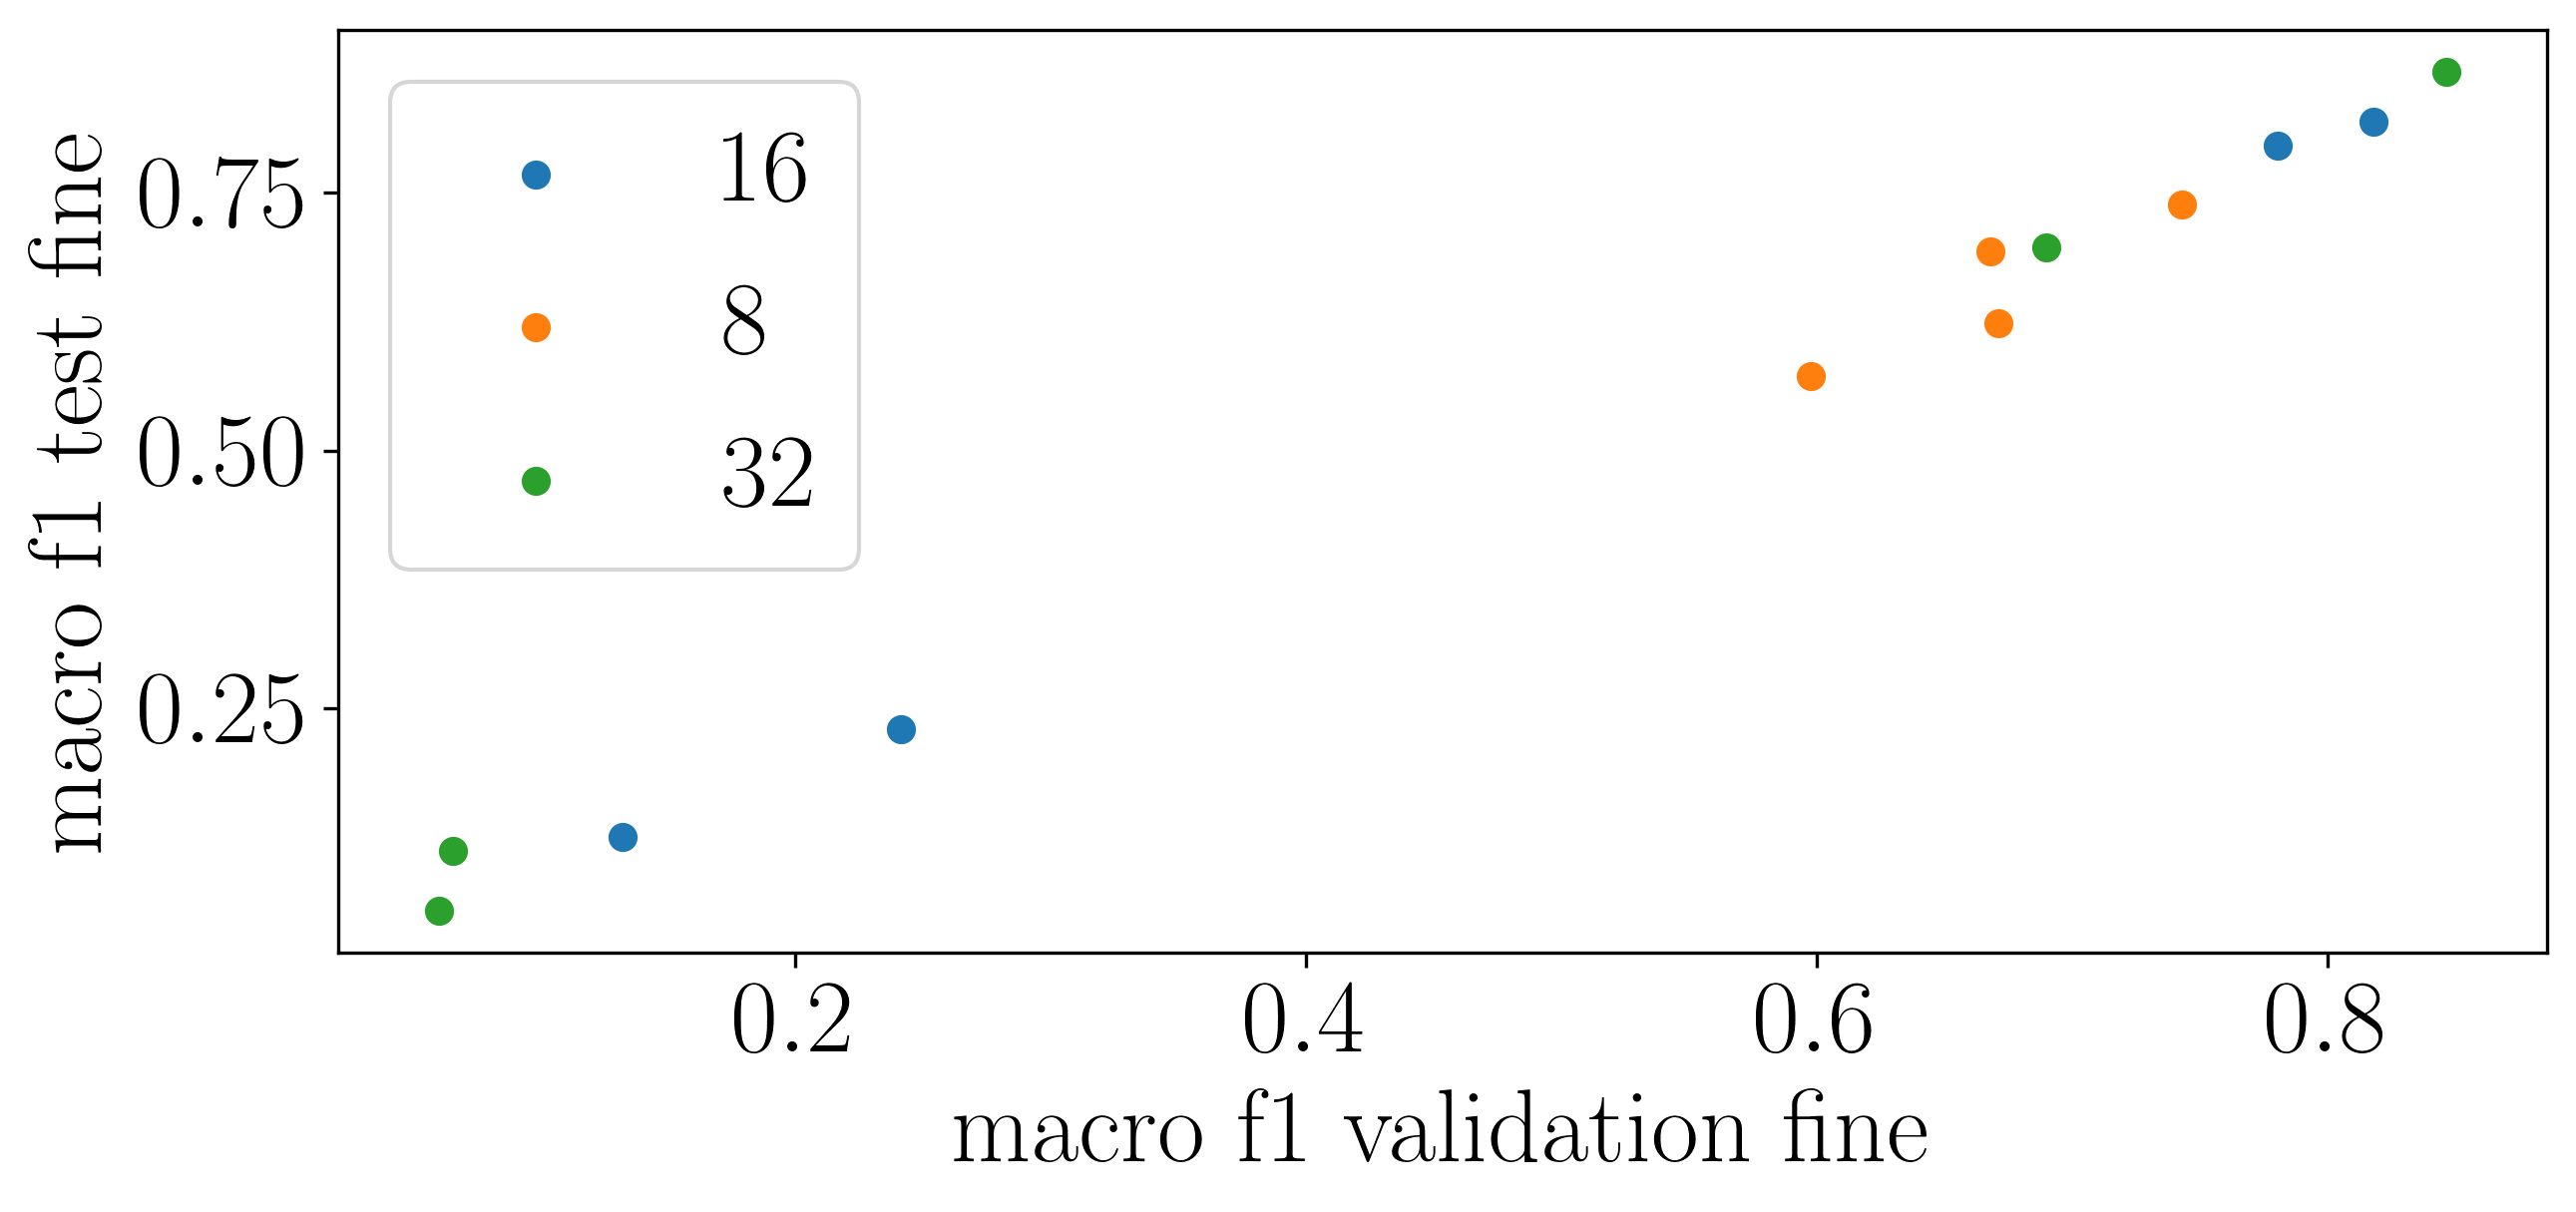

In [24]:
ts.df = ts.df.copy().replace(r"_", "", regex=True)
ts.df.columns = ts.df.columns.str.replace('_','')
ts.trialScatter('macro f1 validation fine', 'macro f1 test fine', aggregatedBy='batchSize', save_plot=True)

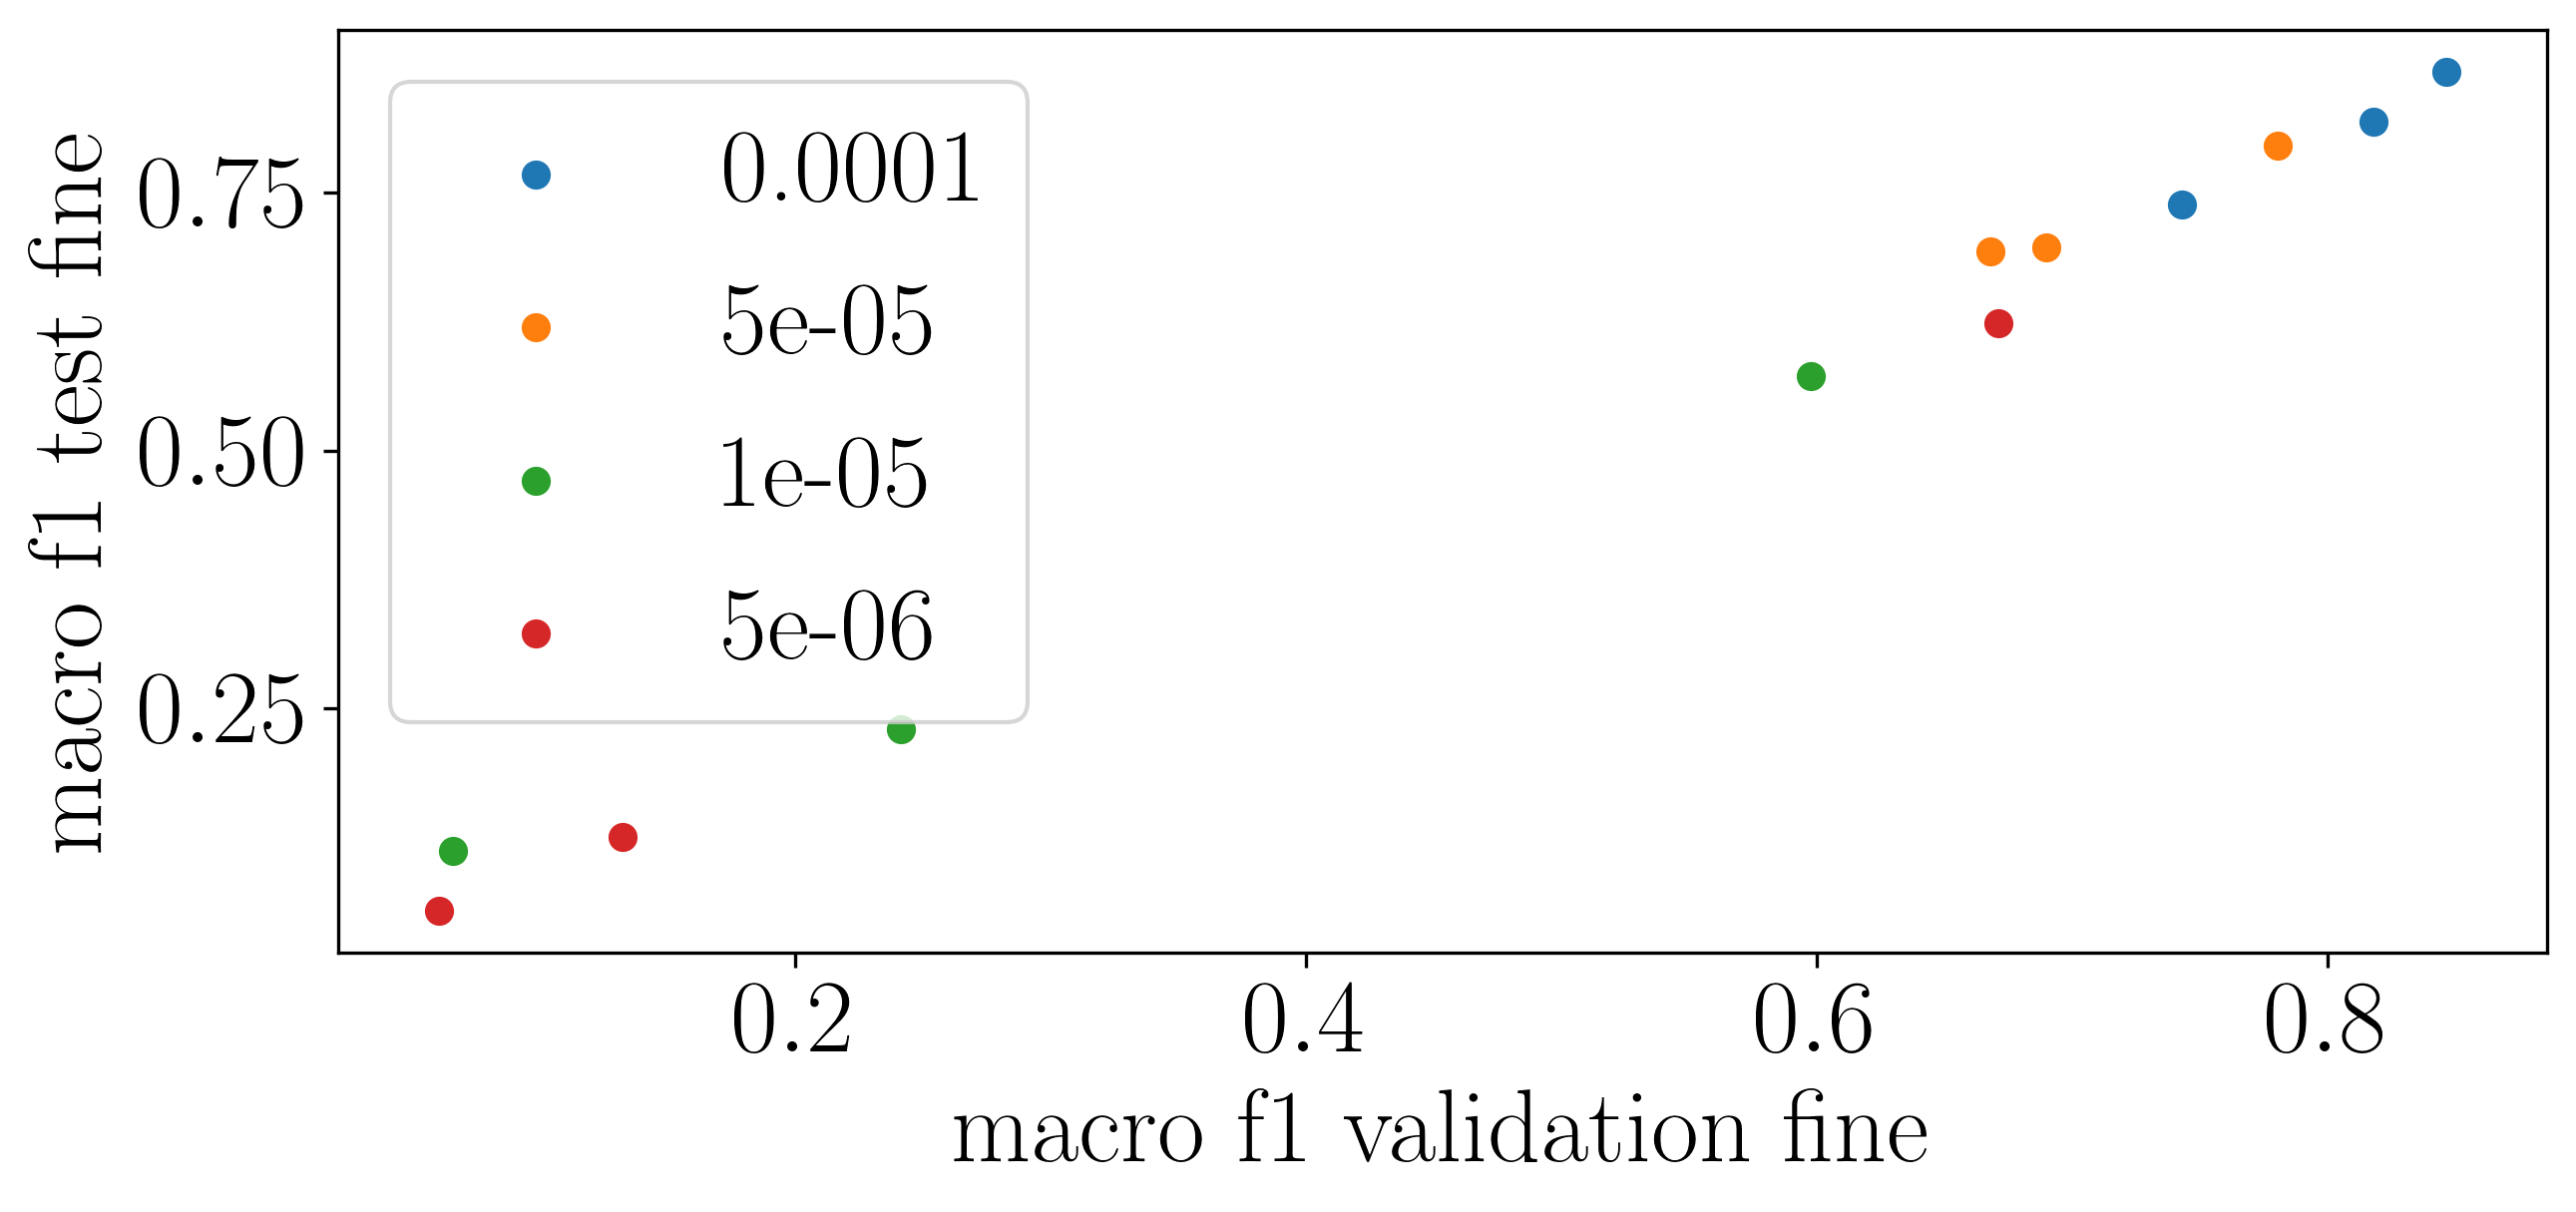

In [25]:
ts.trialScatter('macro f1 validation fine', 'macro f1 test fine', aggregatedBy='learningrate', save_plot=True)

Print scatter plot

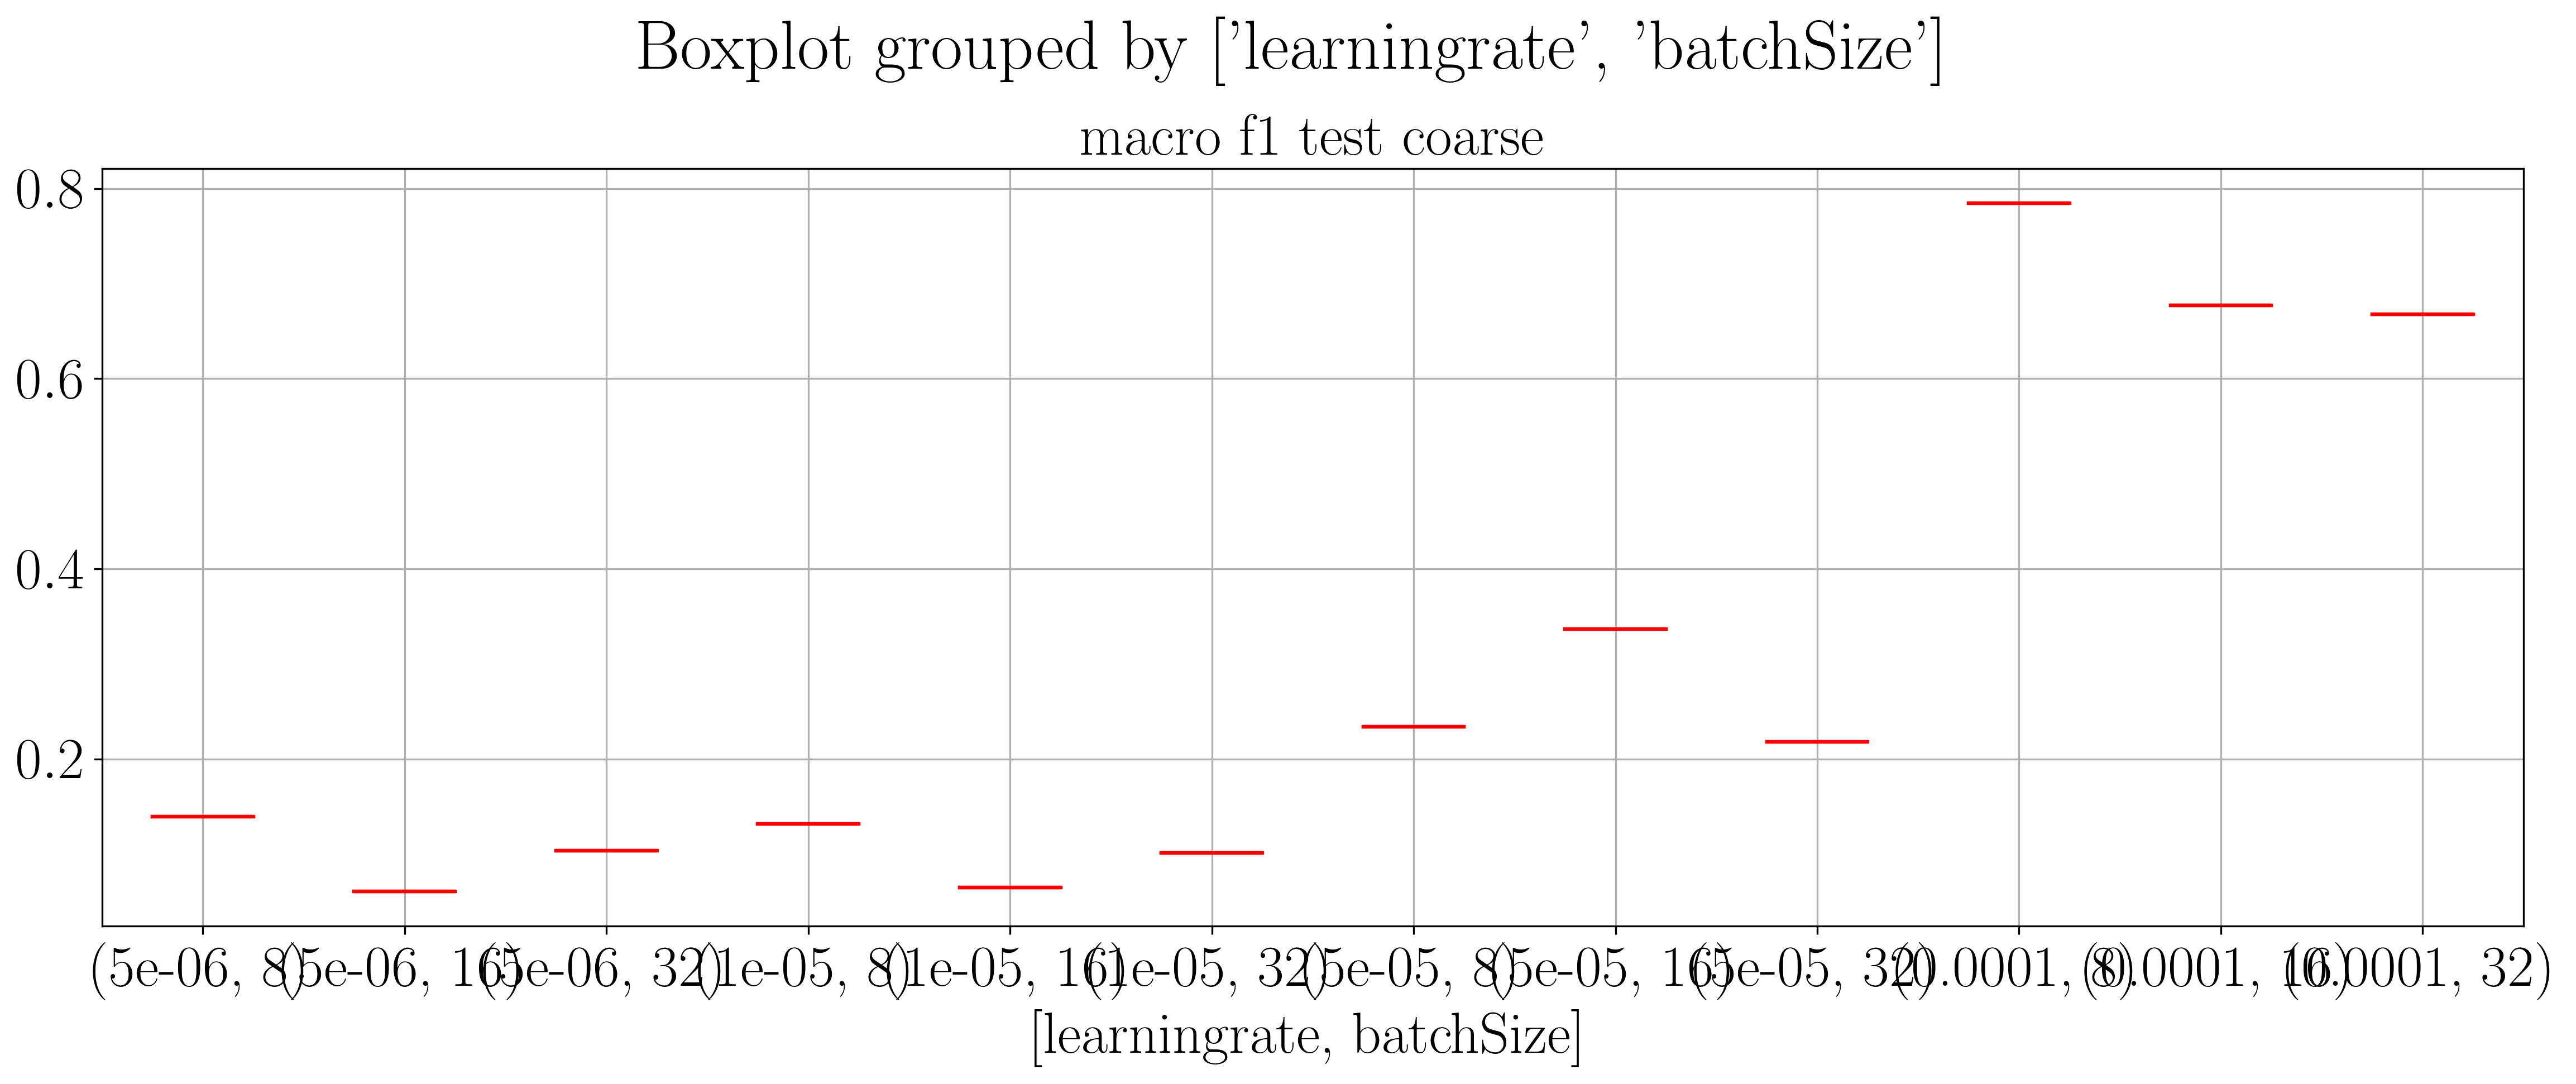

In [16]:
ts.pandasBoxplot(['macro f1 test coarse'], ['learning_rate', 'batchSize'])

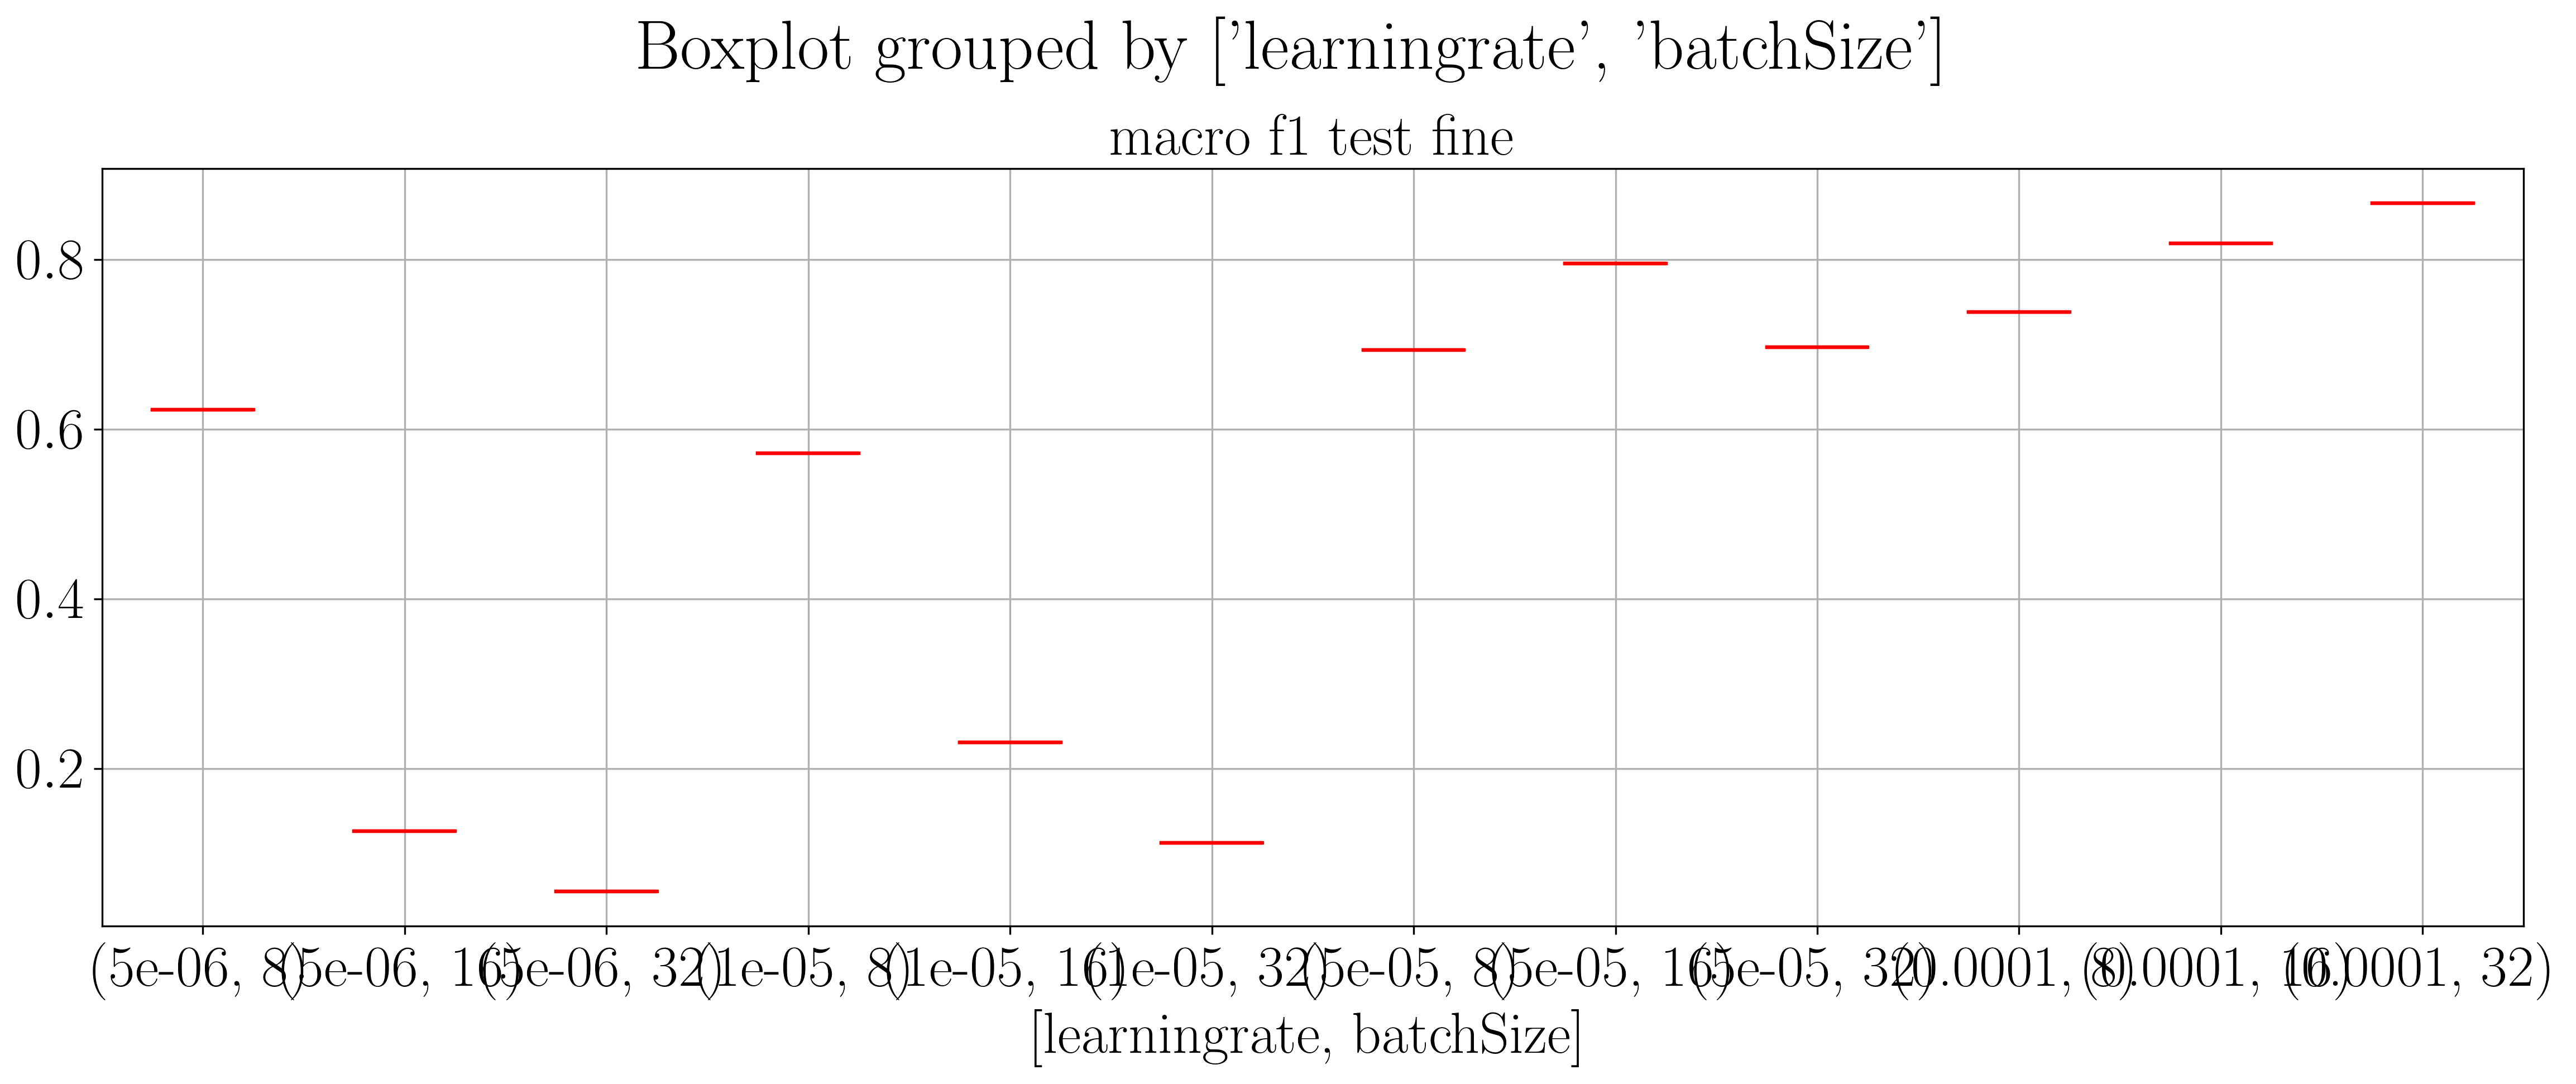

In [17]:
ts.pandasBoxplot(['macro f1 test fine'], ['learning_rate', 'batchSize'])

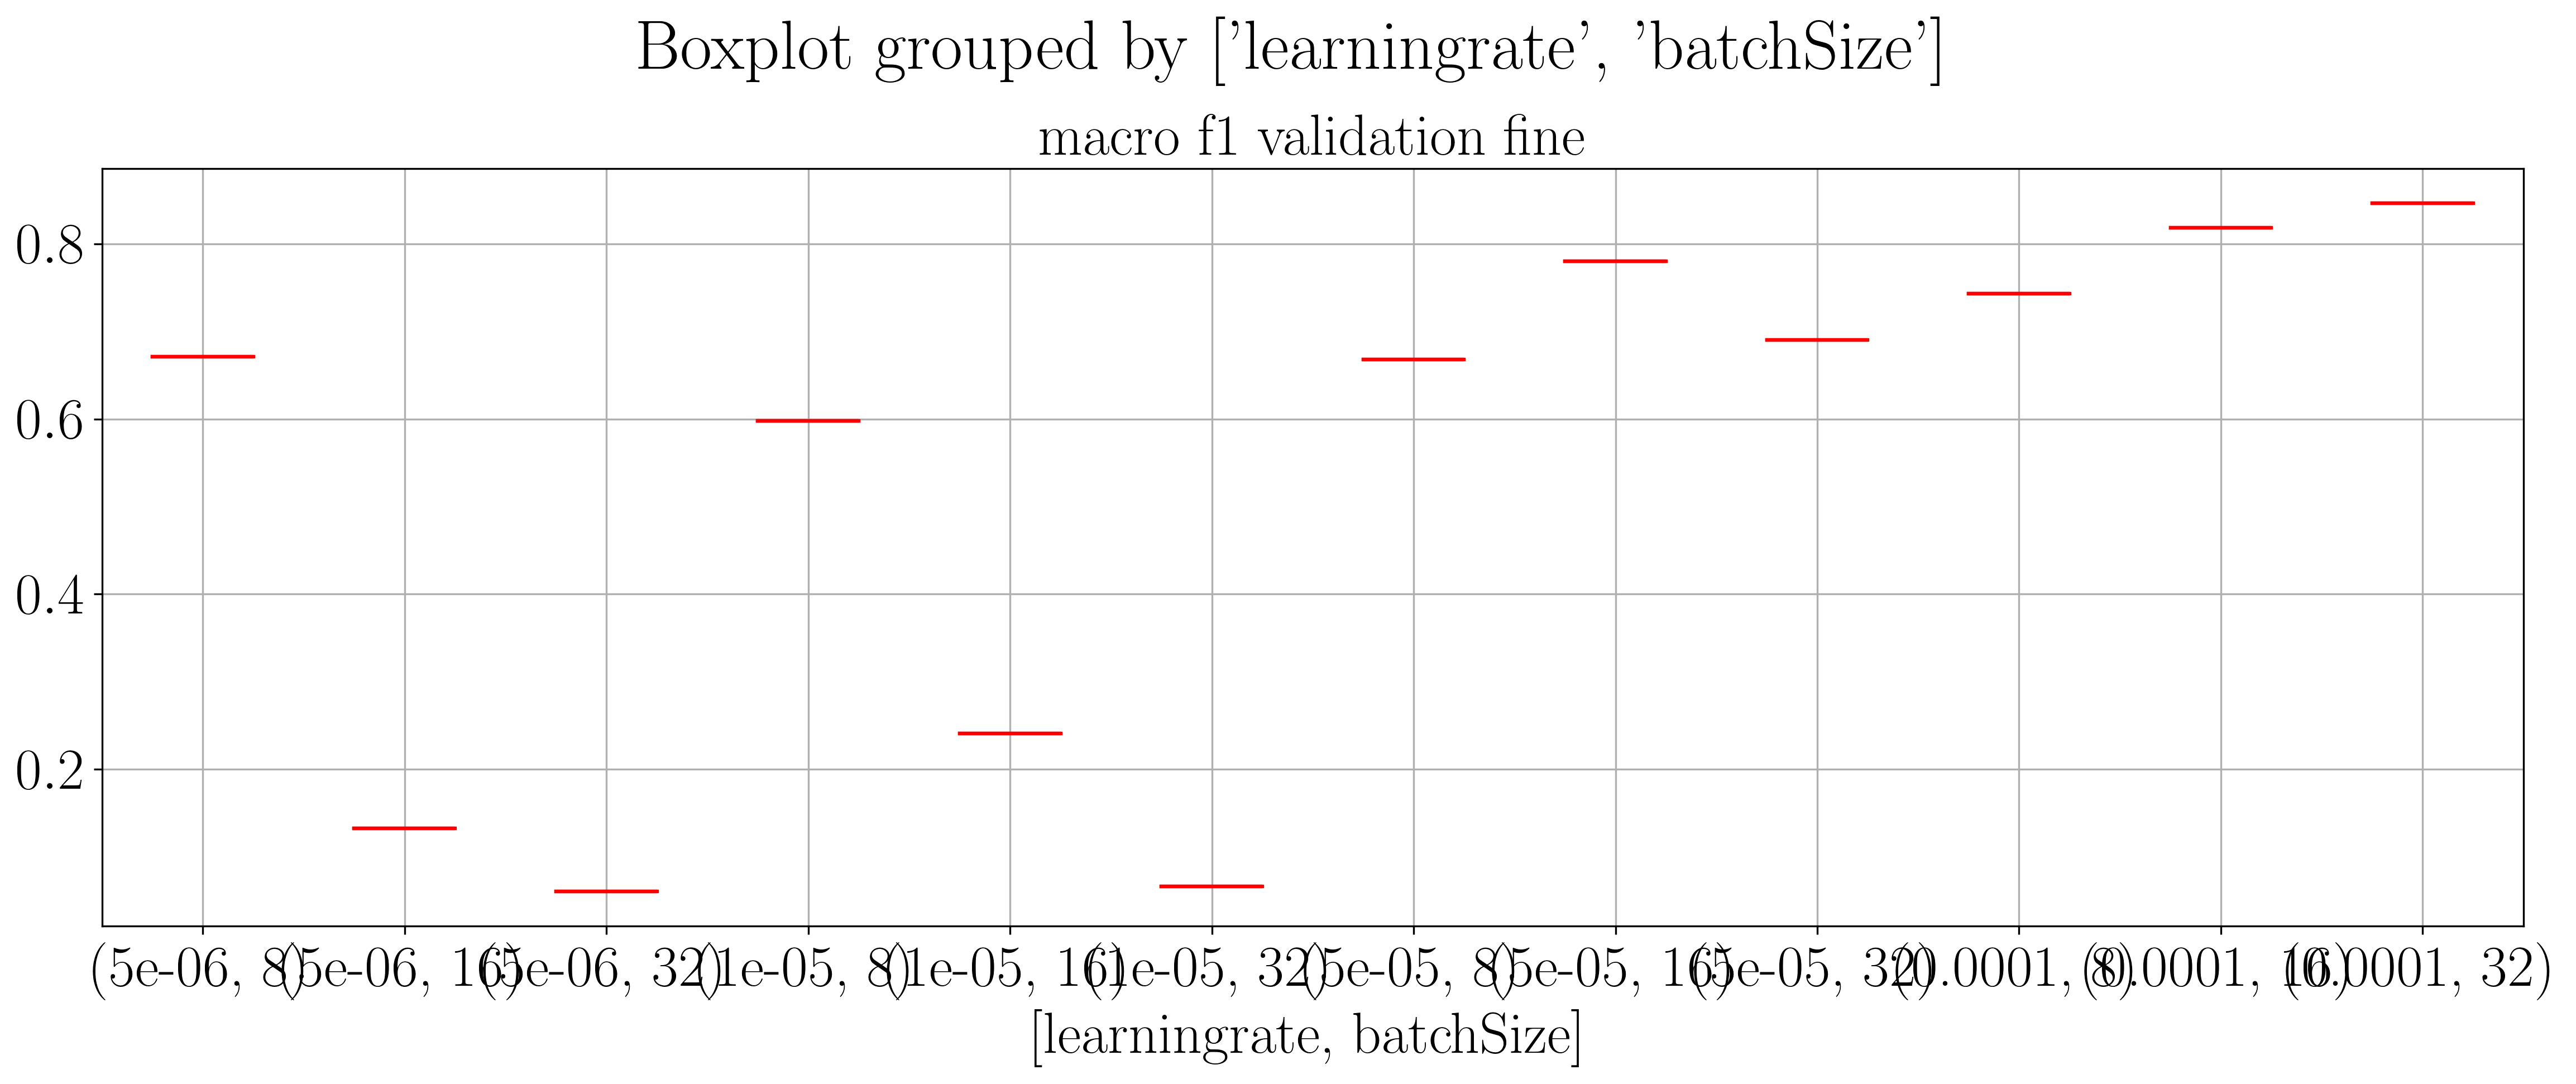

In [18]:
ts.pandasBoxplot(['macro f1 validation fine'], ['learning_rate', 'batchSize'])

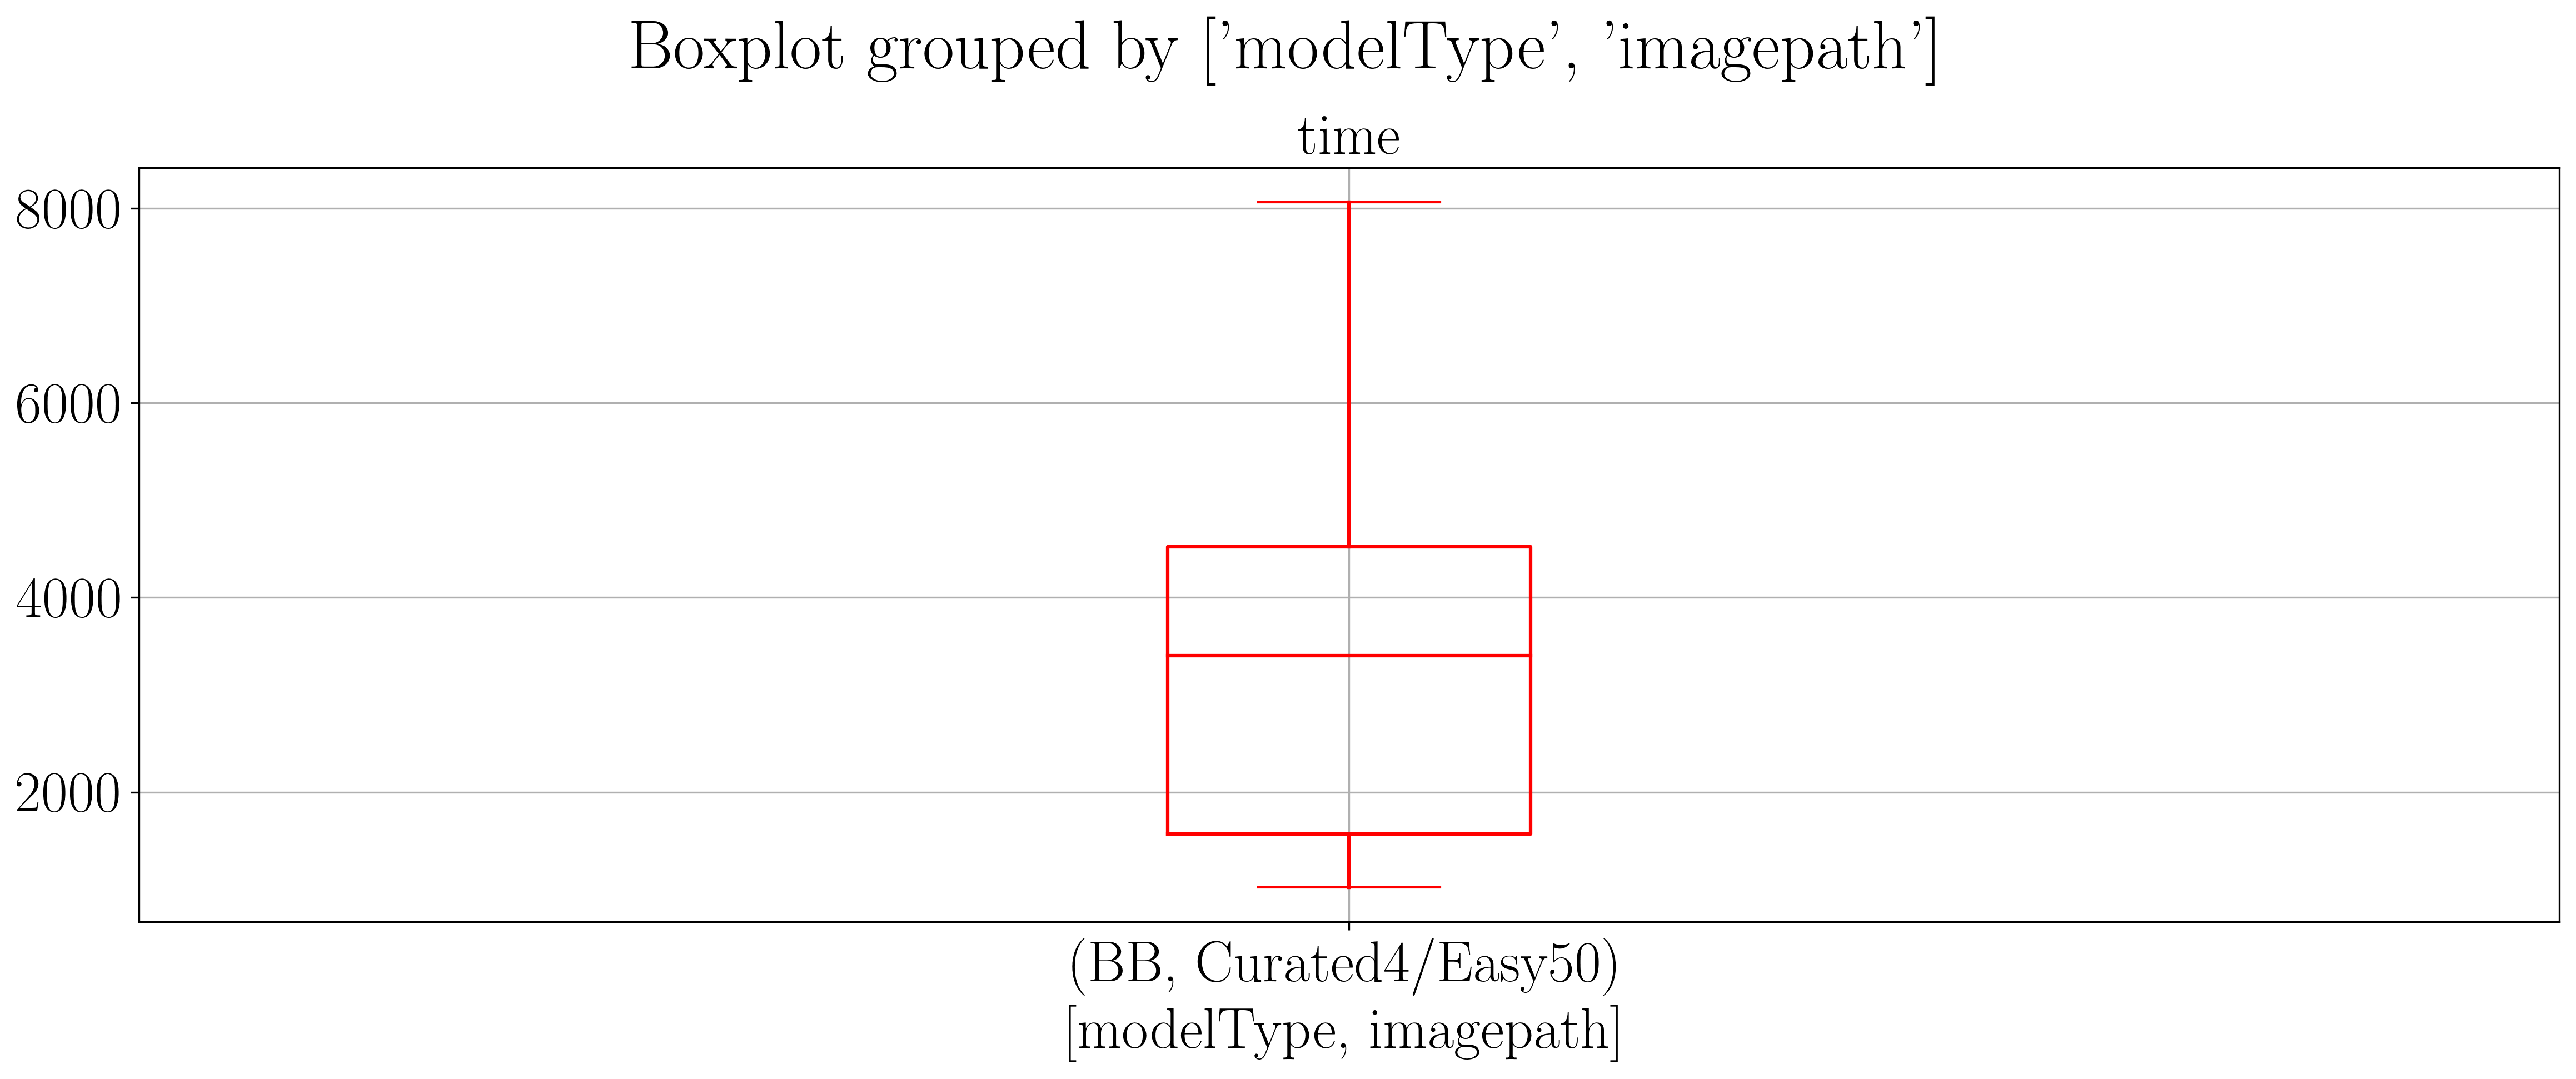

In [14]:
ts.pandasBoxplot(['time'], ['modelType', 'image_path'])

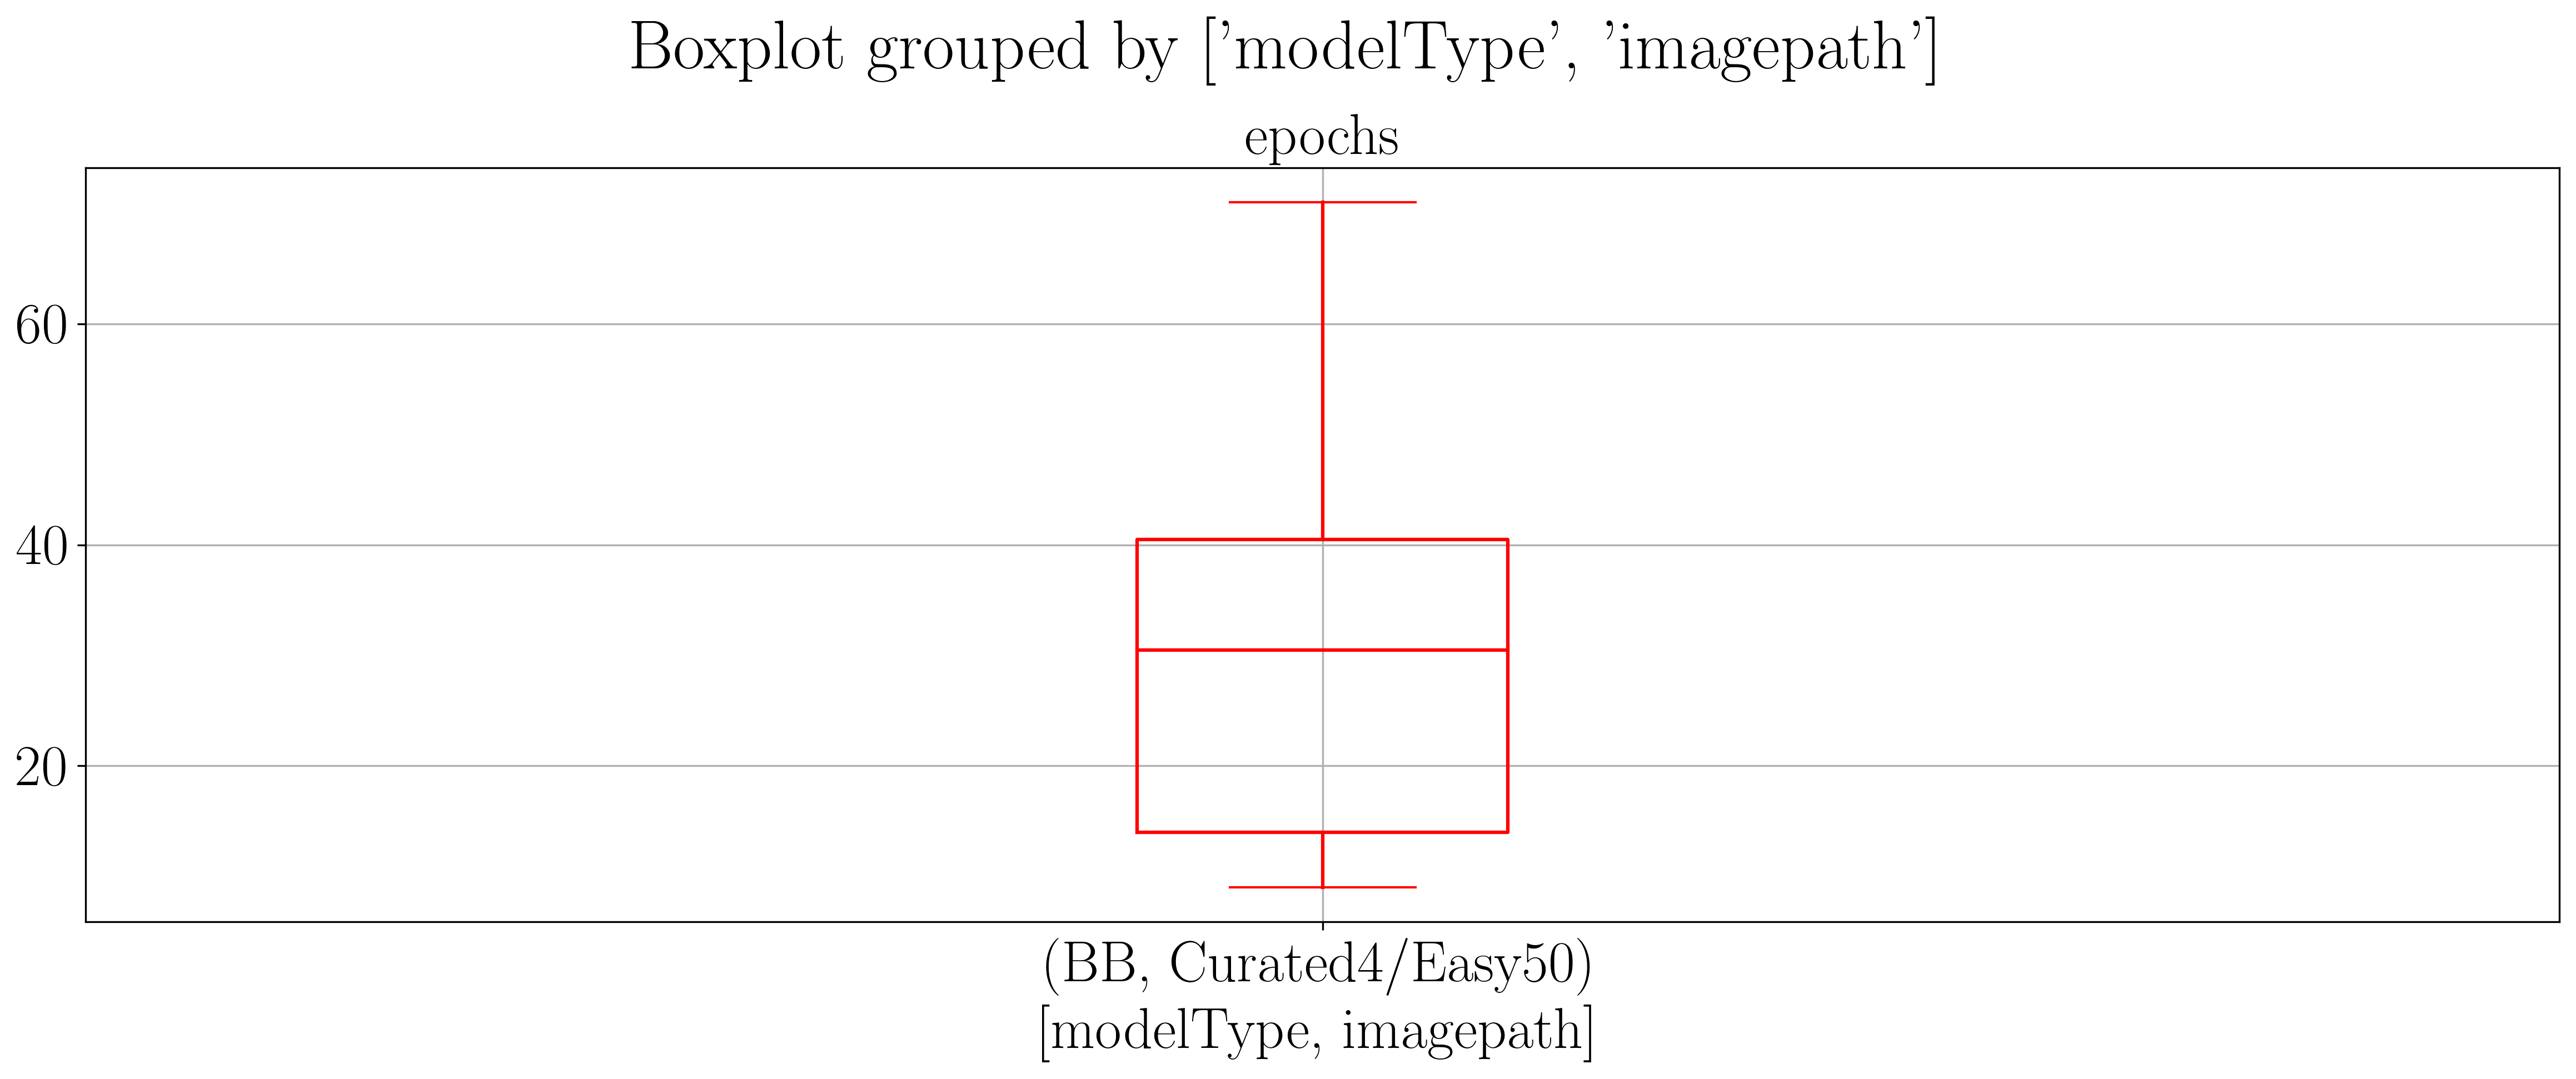

In [15]:
ts.pandasBoxplot(['epochs'], ['modelType', 'image_path'])